In [1]:
!pip install --upgrade scikit-learn

In [2]:
import sklearn
print(sklearn.__version__)

1.5.1


# Healthylife insurance charge prediction - Project 2

## Problem Statement
HealthyLife is a leading insurance company headquartered in New York City, serving customers nationwide with a range of insurance policies, including health, auto, and life insurance. Currently, the company relies on traditional methods to assess insurance charges based on customer details such as age, sex, and BMI. However, they face challenges in accurately predicting insurance charges due to limited insights into how different customer attributes impact premiums. This uncertainty leads to potential underpricing or overpricing of policies, affecting both profitability and customer satisfaction. To address these challenges, the company is looking to leverage advanced predictive modeling techniques to enhance its insurance charge estimation process and provide more accurate and personalized pricing to customers.

## Objective
As a Data Scientist hired by the insurance company, the objective is to develop an app and implement a predictive model for estimating insurance charges based on customer attributes. The primary challenges to solve include improving the accuracy of insurance charge predictions by incorporating various customer attributes, streamlining the underwriting process to enhance efficiency and customer experience, and maintaining regulatory compliance while optimizing pricing strategies also analyze and identify the driftness in model and data to understand the model behavior overtime

By achieving these objectives


*   We aim to achieve more accurate and personalized insurance charge estimations
*   Reducing the risks of underpricing and overpricing
*   Improve customer satisfaction and loyalty through fair and competitive pricing
*   Ensuring transparency and compliance with regulatory requirements in pricing strategies will further strengthen our competitive position in the market and enhance overall business performance









### Import the required libraries

In [3]:
import sklearn
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
sklearn.set_config(display='diagram')

## Import the Data

In [5]:
from google.colab import files
uploaded = files.upload()

Saving insurance.csv to insurance (1).csv


In [6]:
data_df = pd.read_csv('insurance.csv')

In [7]:
data_df.head(10)

,index,age,sex,bmi,children,smoker,region,charges
0,0,19,female,27.900,0,yes,southwest,16884.92400
1,1,18,male,33.770,1,no,southeast,1725.55230
2,2,28,male,33.000,3,no,southeast,4449.46200
3,3,33,male,22.705,0,no,northwest,21984.47061
4,4,32,male,28.880,0,no,northwest,3866.85520
5,5,31,female,25.740,0,no,southeast,3756.62160
6,6,46,female,33.440,1,no,southeast,8240.58960
7,7,37,female,27.740,3,no,northwest,7281.50560
8,8,37,male,29.830,2,no,northeast,6406.41070
9,9,60,female,25.840,0,no,northwest,28923.13692


# split data in to numerical and categorical

In [8]:
target = 'charges'
numeric_features = ['age', 'bmi', 'children', 'charges']
categorical_features = ['sex', 'smoker', 'region']

Display the statistical summary of the numerical, categorical and target data

In [9]:
data_df[numeric_features].describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


#### Write your insights and findings from the statistical summary

* The variables age, bmi and children appear to be normally distributed.
* Half of the customers are charged 9,382 by the insurance company.
* On average, 50% of the customers have at least one child.

In [10]:
data_df[categorical_features].describe()

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


Insights
- While sex and smoker each have two levels, region has four categorical levels
- There are more males, and the majority of customers do not smoke and are predominantly from the southeast.

Exploring the Target variable by categorical variables

In [11]:
# Group by 'sex' summarize 'charges'
summary = data_df.groupby(['sex']).agg(
    count=('charges', 'count'),
    mean_price=('charges', 'mean'),
    median_price=('charges', 'median'),
    min_price=('charges', 'min'),
    max_price=('charges', 'max'),
    std_price=('charges', 'std')
).reset_index()

In [12]:
# Display the summary
print(summary)

      sex  count    mean_price  median_price  min_price    max_price  \
0  female    662  12569.578844    9412.96250  1607.5101  63770.42801   
1    male    676  13956.751178    9369.61575  1121.8739  62592.87309   

      std_price  
0  11128.703801  
1  12971.025915  


Combining all categories and summarizing with charges

In [13]:
# Define a function to summarize charges for each categorical variable
def summarize_by_category(data_df, category):
    summary = data_df.groupby(category)['charges'].agg(
        count='count',
        mean='mean',
        median='median',
        min='min',
        max='max',
        std='std'
    ).reset_index()
    summary['category'] = category
    summary = summary.rename(columns={category: 'value'})
    return summary

In [14]:
# Summarize charges by sex, smoker, and region
summary_sex = summarize_by_category(data_df, 'sex')
summary_smoker = summarize_by_category(data_df, 'smoker')
summary_region = summarize_by_category(data_df, 'region')

In [15]:
# Combine summaries into a single DataFrame
overall_summary = pd.concat([summary_sex, summary_smoker, summary_region], ignore_index=True)

In [16]:
# Display the overall summary
overall_summary

,value,count,mean,median,min,max,std,category
0,female,662,12569.578844,9412.962500,1607.5101,63770.42801,11128.703801,sex
1,male,676,13956.751178,9369.615750,1121.8739,62592.87309,12971.025915,sex
2,no,1064,8434.268298,7345.405300,1121.8739,36910.60803,5993.781819,smoker
3,yes,274,32050.231832,34456.348450,12829.4551,63770.42801,11541.547176,smoker
4,northeast,324,13406.384516,10057.652025,1694.7964,58571.07448,11255.803066,region
5,northwest,325,12417.575374,8965.795750,1621.3402,60021.39897,11072.276928,region
6,southeast,364,14735.411438,9294.131950,1121.8739,63770.42801,13971.098589,region
7,southwest,325,12346.937377,8798.593000,1241.5650,52590.82939,11557.179101,region


Insights:
- In terms of sex, females have higher insurance charges compared to males (9,412 vs. 9,369)
- Customers who smoke pay higher insurance charges (34,456) compared to customers who don't (7,345).
- On average, customers predominantly from the northeast have higher insurance charges (10,057) compared to customers from other regions.

Check the missing values

In [17]:
data_df.isnull().sum()

index       0
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Check duplicated rows

In [18]:
data_df.duplicated().sum()

0

In [19]:
# display the info of the dataset

In [20]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     1338 non-null   int64  
 1   age       1338 non-null   int64  
 2   sex       1338 non-null   object 
 3   bmi       1338 non-null   float64
 4   children  1338 non-null   int64  
 5   smoker    1338 non-null   object 
 6   region    1338 non-null   object 
 7   charges   1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.8+ KB


# drop the columns which was not required for modelling

In [21]:
#Create a copy of the original data
data_df_copy = data_df.copy()

In [22]:
data_df.drop(['index'], axis=1, inplace=True)

In [23]:
data_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Exploratory data analysis

#### Charges amount distribution per sex

# Display a histogram to visualize the distribution of charges based on sex in the dataset

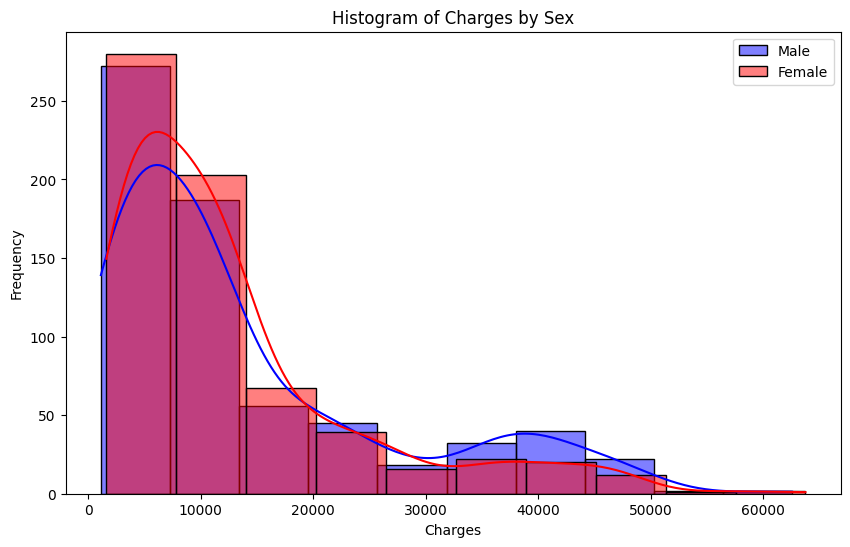

In [24]:
# Plot histograms grouped by sex
plt.figure(figsize=(10, 6))

# Plot histogram for males
sns.histplot(data_df[data_df['sex'] == 'male']['charges'], kde=True, color='blue', label='Male', bins=10, alpha=0.5)

# Plot histogram for females
sns.histplot(data_df[data_df['sex'] == 'female']['charges'], kde=True, color='red', label='Female', bins=10, alpha=0.5)

# Add labels and title
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Histogram of Charges by Sex')
plt.legend()

# Show plot
plt.show()

# Displot of Charges by Sex

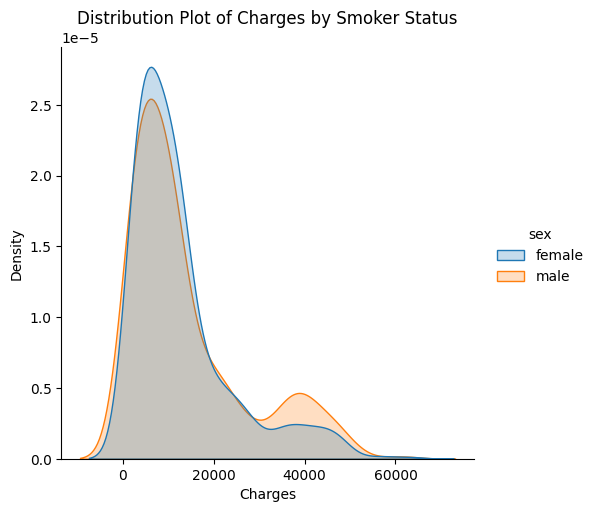

In [25]:
# Plot distribution with seaborn displot
sns.displot(data_df, x='charges', hue='sex', kind='kde', fill=True)

# Add labels and title
plt.xlabel('Charges')
plt.ylabel('Density')
plt.title('Distribution Plot of Charges by Smoker Status')

# Show plot
plt.show()

#### Distribution of Age

# Create a histogram to display the age distribution in the dataset

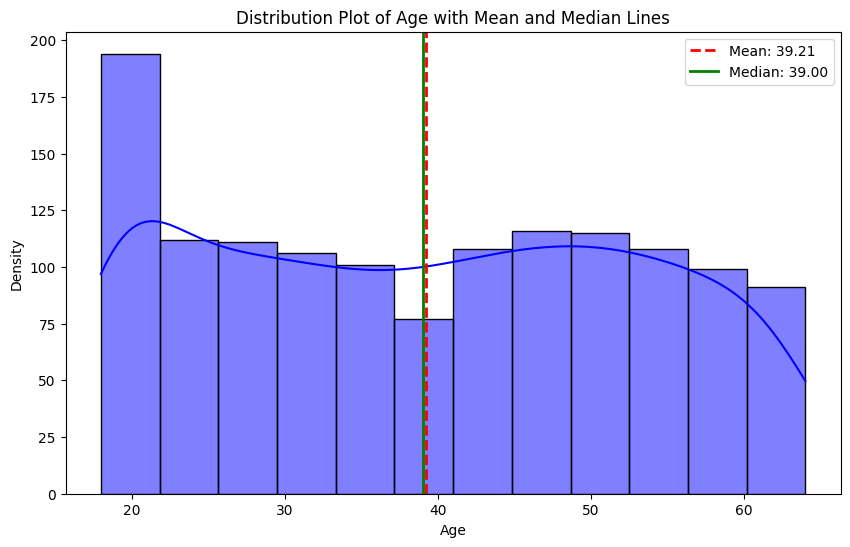

In [26]:
# Calculating mean and median
mean_age = np.mean(data_df['age'])
median_age = np.median(data_df['age'])

# Ploting distribution with seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data_df['age'], kde=True, color='blue')

# Adding mean and median lines
plt.axvline(mean_age, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_age:.2f}')
plt.axvline(median_age, color='green', linestyle='-', linewidth=2, label=f'Median: {median_age:.2f}')

# Adding labels and title
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Distribution Plot of Age with Mean and Median Lines')
plt.legend()

# Show plot
plt.show()

#### Charges amount distribution per smoker

# Show a histogram to visualize the distribution of charges amounts based on smoking status in the dataset

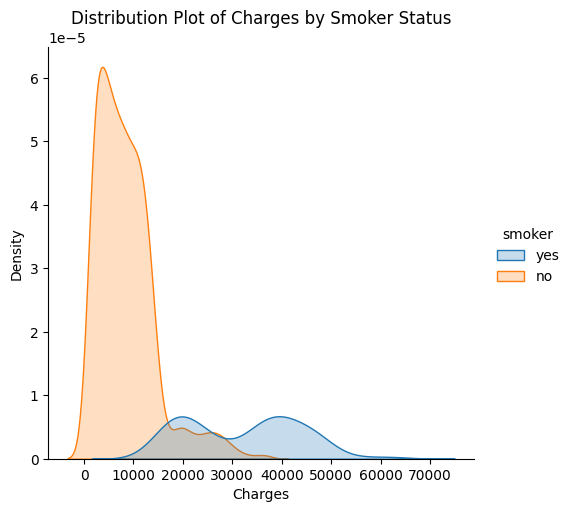

In [27]:
# Plot distribution with seaborn displot
sns.displot(data_df, x='charges', hue='smoker', kind='kde', fill=True)

# Add labels and title
plt.xlabel('Charges')
plt.ylabel('Density')
plt.title('Distribution Plot of Charges by Smoker Status')

# Show plot
plt.show()

#### Average BMI per age

# Display a line plot showing the average BMI per age using markers to highlight the data points

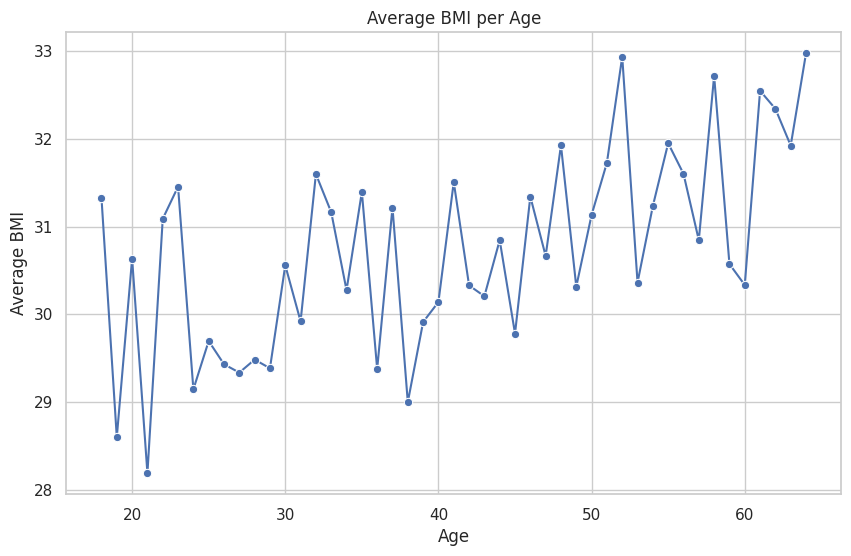

In [28]:
# Calculate average BMI per age
average_bmi_per_age = data_df.groupby('age')['bmi'].mean().reset_index()

# Set the plot style
sns.set(style="whitegrid")

# Create the line plot with markers
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_bmi_per_age, x='age', y='bmi', marker='o')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Average BMI')
plt.title('Average BMI per Age')

# Show plot
plt.show()

As we can see with time - the average BMI score starts getting higher to unhealthier ranges.

#### Age vs charges

# Create a scatter plot to show the relationship between age and charges in the dataset.

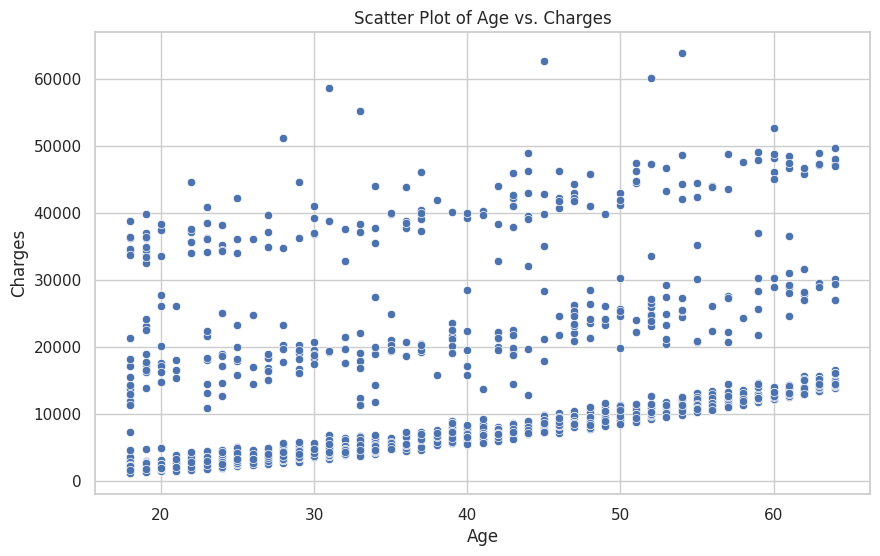

In [29]:
# Set the plot style
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_df, x='age', y='charges')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Charges')
plt.title('Scatter Plot of Age vs. Charges')

# Show plot
plt.show()

## Model Estimation

# write you are code here

In [30]:
X = data_df[numeric_features + categorical_features]
y = data_df[target]

In [31]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [32]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features)
)

In [33]:
model_linear_regression = LinearRegression(n_jobs=-1)

In [34]:
model_pipeline = make_pipeline(
    preprocessor,
    model_linear_regression
)

In [35]:
model_pipeline.fit(Xtrain, ytrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'bmi', 'children',
                                                   'charges']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('linearregression', LinearRegression(n_jobs=-1))])

## Model Evaluation

# write your code here

In [36]:
model_pipeline.predict(Xtest)

array([ 9095.06825 ,  5272.1758  , 29330.98315 ,  9301.89355 ,
       33750.2918  ,  4536.259   ,  2117.33885 , 14210.53595 ,
        3732.6251  , 10264.4421  , 18259.216   ,  7256.7231  ,
        3947.4131  , 46151.1245  , 48673.5588  , 44202.6536  ,
        9800.8882  , 42969.8527  ,  8233.0975  , 21774.32215 ,
        5080.096   ,  7441.501   ,  1256.299   ,  2755.02095 ,
       11085.5868  , 10923.9332  , 12644.589   , 18804.7524  ,
        9715.841   ,  1131.5066  , 15828.82173 , 11842.62375 ,
        2020.5523  ,  5693.4305  ,  2904.088   ,  7448.40395 ,
        2597.779   ,  7337.748   , 23887.6627  , 38709.176   ,
        4687.797   ,  2643.2685  , 11674.13    , 12124.9924  ,
        4889.9995  , 12333.828   ,  3579.8287  ,  4391.652   ,
       42124.5153  ,  4463.2051  , 13887.204   ,  1719.4363  ,
       28476.73499 ,  1708.92575 , 10594.2257  , 25333.33284 ,
        3645.0894  , 38746.3551  , 11848.141   , 10564.8845  ,
       13880.949   ,  4753.6368  , 27941.28758 ,  8017.

In [37]:
print(f"RMSE: {root_mean_squared_error(ytest, model_pipeline.predict(Xtest), squared=False)}")

RMSE: 2.24229837346852e-11


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [38]:
print(f"R-squared: {r2_score(ytest, model_pipeline.predict(Xtest))}")

R-squared: 1.0


## Serialization

# Display information about the scikit-learn package

In [39]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.5.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, qudida, sklearn-pandas, yellowbrick


# Generate a requirements.txt file for the project's dependencies

In [40]:
%%writefile requirements.txt
scikit-learn==1.5.1

Overwriting requirements.txt


# Create a training script which we can use to train and save model

In [41]:
%%writefile train.py

import joblib
import pandas as pd

from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


data_df = pd.read_csv('insurance.csv')

target = 'charges'
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

print("Creating data subsets")

X = data_df[numeric_features + categorical_features]
y = data_df[target]

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features)
)

model_linear_regression = LinearRegression(n_jobs=-1)

print("Estimating Model Pipeline")

model_pipeline = make_pipeline(
    preprocessor,
    model_linear_regression
)

model_pipeline.fit(Xtrain, ytrain)

print("Logging Metrics")
print(f"R-squared: {r2_score(ytest, model_pipeline.predict(Xtest))}")

print("Serializing Model")

saved_model_path = "model.joblib"

joblib.dump(model_pipeline, saved_model_path)

Overwriting train.py


# Execute the training script

In [42]:
!python train.py

Creating data subsets
Estimating Model Pipeline
Logging Metrics
R-squared: 0.7835929767120722
Serializing Model


## Test Predictions

# write you are code here

In [43]:
saved_model = joblib.load("model.joblib")

In [44]:
saved_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('linearregression', LinearRegression(n_jobs=-1))])

In [45]:
saved_model.predict(Xtest)

array([ 8969.55027444,  7068.74744287, 36858.41091155,  9454.67850053,
       26973.17345656, 10864.11316424,   170.28084136, 16903.45028662,
        1092.43093614, 11218.34318352, 28101.68455267,  9377.73460205,
        5263.0595179 , 38416.04221107, 40255.82339284, 37098.25353123,
       15240.39392306, 35912.88264434,  9112.52398703, 31461.92108909,
        3847.68845883, 10130.12001517,  2370.54189389,  7140.21550828,
       11301.76782638, 12961.65366224, 14509.47251876,  6159.8976107 ,
        9963.85857263,  2177.85718217,  9115.93673493, 13073.68932159,
        4561.82376202,  3408.20756033,  4459.81359745, 13032.06505076,
        1979.99357292,  8813.28303302, 33271.29124448, 32585.51583927,
        3908.76090964,  4326.10774721, 14142.81326533, 11423.45494846,
        8774.13955311, 12097.28051001,  5281.57353499,  3150.5596042 ,
       35494.46461214,  9150.1124786 , 15836.84575621,  2343.57470069,
       12364.78414194,  1482.29488266, 13389.06105161, 12573.57395972,
      

# Gradio Interface

In [46]:
%%writefile app.py
# Import the libraries
import os
import uuid
import joblib
import json
import gradio as gr
import pandas as pd
from huggingface_hub import CommitScheduler
from pathlib import Path

# Prepare the logging functionality
log_file = Path("logs/") / f"data_{uuid.uuid4()}.json"
log_folder = log_file.parent

# scheduler = CommitScheduler(
#     repo_id="insurance-charge-logs",
#     repo_type="dataset",
#     folder_path=log_folder,
#     path_in_repo="data",
#     every=2
# )

# Load the freshly trained model from disk
try:
    machine_insurance_predictor = joblib.load('model.joblib')
except Exception as e:
    print(f"Error loading model: {e}")

age_input = gr.Number(label='Age')
bmi_input = gr.Number(label='BMI')
children_input = gr.Number(label='Children')
sex_input = gr.Dropdown(
    ['male', 'female'],
    label='Sex'
)
smoker_input = gr.Dropdown(
    ['yes', 'no'],
    label='Smoker'
)
region_input = gr.Dropdown(
    ['northeast', 'northwest', 'southeast', 'southwest'],
    label='Region'
)

model_output = gr.Label(label="Insurance Charge")

# Define the predict function which will take features, convert to dataframe, and make predictions using the saved model
# The function runs when 'Submit' is clicked or when an API request is made
# While the prediction is made, log both the inputs and outputs to a log file
# While writing to the log file, ensure that the commit scheduler is locked to avoid parallel access

def predict_insurance_charge(age, bmi, children, sex, smoker, region):
    try:
        sample = {
            'age': age,
            'bmi': bmi,
            'children': children,
            'sex': sex,
            'smoker': smoker,
            'region': region,
        }
        data_point = pd.DataFrame([sample])
        prediction = machine_insurance_predictor.predict(data_point).tolist()

        # with scheduler.lock:
        #     with log_file.open("a") as f:
        #         f.write(json.dumps(
        #             {
        #                 'Age': age,
        #                 'BMI': bmi,
        #                 'Children': children,
        #                 'Sex': sex,
        #                 'Smoker': smoker,
        #                 'Region': region,
        #                 'prediction': prediction[0]
        #             }
        #         ))
        #         f.write("\n")

        return f"Predicted Insurance Charge: ${prediction[0]:.2f}"
    except Exception as e:
        return f"Error: {str(e)}"

# Create the Gradio interface, make title "HealthyLife Insurance Charge Prediction"
# Set up UI components for input and output
demo = gr.Interface(
    fn=predict_insurance_charge,
    inputs=[age_input, bmi_input, children_input, sex_input,
            smoker_input, region_input],
    outputs=model_output,
    title="Insurance Charge Predictor",
    description="This API allows you to predict the company's insurance charges",
    allow_flagging="auto",
    concurrency_limit=8
)

# Launch with a load balancer
demo.queue()
demo.launch(share=False)

# Run the training script placed in the same directory as app.py
# The training script will train and persist a linear regression
# model with the filename 'model.joblib'

Overwriting app.py


# Online/Batch Inferencing

### Paste your gradio app link

*   app link: https://huggingface.co/spaces/amobionovo/Dr.Amobi_Insurance_Charge_Prediction_App

Note: Make sure your Hugging Face space repository is set to public. If it's private, the evaluator won't be able to access the app you've built, which could result in losing marks.

In [47]:
# Install the gradio_client package silently
!pip install -q gradio_client

In [48]:
# import the libraries
import time  # Import the time module for time-related functions
from gradio_client import Client  # Import the Gradio client for interacting with Gradio interfaces
from sklearn.datasets import fetch_openml  # Import fetch_openml to fetch datasets
from sklearn.model_selection import train_test_split  # Import train_test_split for splitting datasets
from tqdm import tqdm  # Import tqdm for progress bars

In [49]:
client = Client("amobionovo/Dr.Amobi_Insurance_Charge_Prediction_App")
result = client.predict(
		age=3,
		bmi=3,
		children=3,
		sex="male",
		smoker="yes",
		region="northeast",
		api_name="/predict"
)
print(result)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded as API: https://amobionovo-dr-amobi-insurance-charge-prediction-app.hf.space ✔
{'label': 'Predicted Insurance Charge: $14759.36', 'confidences': None}


## Test Data

In [50]:
# Read the insurance dataset from a CSV file into a DataFrame
data_df = pd.read_csv('insurance.csv')

# Define the target variable
target = 'charges'

# Define the numeric features used for modeling
numeric_features = ['age', 'bmi', 'children']

# Define the categorical features used for modeling
categorical_features = ['sex', 'smoker', 'region']

# Print a message indicating that data subsets are being created
print("Creating data subsets")

# Create a variable X by combining numeric and categorical features
X = data_df[numeric_features + categorical_features]

# Create the target variable y
y = data_df[target]

# Split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

Creating data subsets


In [51]:
# Check the shape of the testing features dataset
Xtest.shape


(268, 6)

In [52]:
# Display the first 3 rows of the testing features dataset
Xtest.head(3)


,age,bmi,children,sex,smoker,region
764,45,25.175,2,female,no,northeast
887,36,30.020,0,female,no,northwest
890,64,26.885,0,female,yes,northwest


In [53]:
len(Xtest)

268

In [54]:
# Retrieve the values of a specific row (index 764) from the testing features dataset and convert them to a list
# Check the length of the DataFrame
num_rows = len(Xtest)
print(f"Number of rows in Xtest: {num_rows}")

# Use a valid index to retrieve the values
valid_index = min(764, num_rows - 1)  # Ensure the index is within bounds

# Retrieve the values of the specific row and convert them to a list
row_values = Xtest.iloc[valid_index].tolist()
print(row_values)


Number of rows in Xtest: 268
[51, 34.2, 1, 'female', 'no', 'southwest']


In [55]:
# Randomly sample 100 rows from the testing features dataset
Xtest_sample_rows = Xtest.sample(n=100, random_state=42)


In [56]:
# Convert the sampled rows from the DataFrame to a list of tuples
Xtest_sample_rows = Xtest_sample_rows.values.tolist


In [57]:
# Access the first tuple in the list of sampled rows
# Sample some rows from the DataFrame
Xtest_sample_rows = Xtest.sample(n=5, random_state=1)  # Sample 5 rows for example

# Convert the sampled rows to a list of tuples
sampled_rows_list = [tuple(row) for row in Xtest_sample_rows.values]

# Access the first tuple in the list of sampled rows
first_tuple = sampled_rows_list[0]

print(first_tuple)

(29, 29.59, 1, 'female', 'no', 'southeast')


## Inference

In [58]:
# Create a Gradio client instance for the specified Gradio interface
client = Client("amobionovo/Dr.Amobi_Insurance_Charge_Prediction_App")


Loaded as API: https://amobionovo-dr-amobi-insurance-charge-prediction-app.hf.space ✔


## Online/Real time

In [59]:
# Submit a single data point prediction request to the Gradio interface
job = client.submit(
    age=21,
    bmi=38,
    children=2,
    sex="male",
    smoker="yes",
    region="northeast",
    api_name="/predict"
)

In [60]:
# Print the result of the prediction job
print(job.result())


{'label': 'Predicted Insurance Charge: $30757.88', 'confidences': None}


## Batch

In [61]:
# Initialize an empty list to store batch predictions
batch_predictions = []

In [62]:
# Iterate through the sampled rows and submit prediction requests to the Gradio interface
# Store the results in batch_predictions list
from tqdm import tqdm
import time

batch_predictions = []

# Ensure Xtest_sample_rows is a DataFrame or a list of tuples/lists
for row in tqdm(Xtest_sample_rows.itertuples(index=False, name=None)):
    try:
        # Check if row has the expected number of elements
        if len(row) < 5:
            print(f"Row has insufficient elements: {row}")
            continue

        # Submit a prediction request for the current row
        job = client.submit(
            age=row[0],
            bmi=row[1],
            children=row[2],
            sex=row[3],
            smoker=row[4],
            region=row[5],
            api_name="/predict"
        )

        # Retrieve the prediction result
        prediction = job.result()  # Assuming job.result() returns the prediction

        # Append the prediction result to batch_predictions
        batch_predictions.append(prediction)

        # Sleep for 1 second before the next request
        time.sleep(1)

    except IndexError as e:
        # Print IndexError if row access is out of range
        print(f"IndexError: {e} for row {row}")
    except Exception as e:
        # Print any other exceptions that occur during the prediction
        print(f"Error: {e} for row {row}")

5it [00:08,  1.72s/it]


In [63]:
# Display the first 5 predictions from the batch_predictions list
batch_predictions[0:5]

[{'label': 'Predicted Insurance Charge: $5263.06', 'confidences': None},
 {'label': 'Predicted Insurance Charge: $33271.29', 'confidences': None},
 {'label': 'Predicted Insurance Charge: $8152.03', 'confidences': None},
 {'label': 'Predicted Insurance Charge: $6507.31', 'confidences': None},
 {'label': 'Predicted Insurance Charge: $10159.52', 'confidences': None}]

# Unit Testing

## Setup

In [64]:
# Install the gradio_client package silently using pip
!pip install -q gradio_client

In [65]:
# import the required libraries
from gradio_client import Client
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

In [66]:
client = Client("amobionovo/Dr.Amobi_Insurance_Charge_Prediction_App")

Loaded as API: https://amobionovo-dr-amobi-insurance-charge-prediction-app.hf.space ✔


## Baseline Checks

Test Data

In [67]:
# Read the insurance dataset from a CSV file into a DataFrame
data_df = pd.read_csv('insurance.csv')

# Define the target variable
target = 'charges'

# Define the numeric features used for modeling
numeric_features = ['age', 'bmi', 'children']

# Define the categorical features used for modeling
categorical_features = ['sex', 'smoker', 'region']

# Print a message indicating that data subsets are being created
print("Creating data subsets")

# Create a variable X by combining numeric and categorical features
X = data_df[numeric_features + categorical_features]

# Create the target variable y
y = data_df[target]

# Split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# Sample 100 rows from the testing set for evaluation
Xtest_sample = Xtest.sample(100)
ytest_sample = ytest.loc[Xtest_sample.index]

# Convert the sampled test set into a list of tuples
Xtest_sample_rows = list(Xtest_sample.itertuples(index=False, name=None))


Creating data subsets


Predictions on the test data

In [68]:
from tqdm import tqdm
import time

# Initialize an empty list to store baseline test predictions
baseline_test_predictions = []

# Iterate over each row in the sampled test set
for row in tqdm(Xtest_sample_rows):
    try:
        # Submit a prediction request for the current row
        job = client.submit(
            age=row[0],
            bmi=row[1],
            children=row[2],
            sex=row[3],
            smoker=row[4],
            region=row[5],
            api_name="/predict"
        )

        # Retrieve the prediction result
        prediction_result = job.result()

        # Check if 'label' exists in the prediction result and is a valid number
        if 'label' in prediction_result:
            prediction = prediction_result['label']
            try:
                # Extract the numerical part from the prediction string
                prediction_value = float(prediction.split('$')[1])
                baseline_test_predictions.append(int(round(prediction_value)))
            except (IndexError, ValueError) as e:
                print(f"Invalid prediction format: {prediction}. Error: {e}")
        else:
            print(f"'label' not found in prediction result: {prediction_result}")

        # Sleep for 1 second before the next request
        time.sleep(1)

    except Exception as e:
        print(e)

# Print the collected baseline test predictions
print(baseline_test_predictions)

100%|██████████| 100/100 [02:27<00:00,  1.48s/it]

[4342, 30842, 12319, 32000, 3929, 3734, 11218, 13167, 6888, 6378, 9167, 36858, 1684, 14345, 4575, 9455, 5886, 10595, 35278, 2493, 10730, 1980, 2371, 4368, 38670, 26343, 5919, 33030, 9481, 7590, 11569, 31313, 9116, 4814, 37098, 32112, 3897, 8440, 2526, 9942, 34847, 12097, 2048, 29444, 5648, 10981, 14807, 10160, 32963, 11839, 3782, 5193, 10567, 3408, 14474, 6780, 35774, 11123, 31462, 7764, 4603, 7430, 36314, 6160, 10483, 4562, 4061, 31686, 36501, 8232, 6581, 26652, 10506, 15076, 3854, 5125, 2223, 37260, 33916, 8411, 10864, 28102, 9814, 28918, 32165, 14509, 14552, 15191, 6209, 10858, 33271, 8362, 28308, 8774, 2376, 1048, 12012, 9344, 5263, 12365]


Estimation of accuracy on the test sample. use RMSE and R-squared to measure the performance of the model

In [69]:
print(f"RMSE: {mean_squared_error(ytest_sample, baseline_test_predictions, squared=False)}")

RMSE: 6040.11393804062


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [70]:
print(f"R-squared: {r2_score(ytest_sample, baseline_test_predictions)}")

R-squared: 0.7696188618661354


If the Mean Absolute Error (MAE) or Root Mean Square Error (RMSE) is lower than the existing baseline (human or a previous model version), we move on to unit tests.

## Unit Tests

### Perturbation tests

*Baseline*

In [71]:
job = client.submit(
    age=28,
    bmi=48,
    children=5,
    sex="male",
    smoker="no",
    region="northeast",
    api_name="/predict"
)

In [72]:
print(job.result()['label'])

Predicted Insurance Charge: $13552.35


*Test (perturbed baseline)*

In [73]:
job = client.submit(
    age=30,
    bmi=48,
    children=5,
    sex="male",
    smoker="no",
    region="northeast",
    api_name="/predict"
)

In [74]:
print(job.result()['label'])

Predicted Insurance Charge: $14066.30


### Known edge-cases (criticial subgroups)

In this scenario, a known edge case is that when a person is smoker , the insurance charge should be high. Let us see if the model can recognize this state.

In [75]:
job = client.submit(
    age=65,
    bmi=42,
    children=2,
    sex="female",
    smoker="no",
    region="southwest",
    api_name="/predict"
)

In [76]:
print(job.result()['label'])

Predicted Insurance Charge: $18970.85


If the unit tests pass, the model is ready to be tagged for release to staging and production.

# Identify the driftness in model and data

## Setup

In [77]:
# !pip install -q datasets
!pip install -q datasets

In [78]:
!pip install --upgrade pyarrow datasets

In [79]:
import pyarrow
from datasets import load_dataset

In [80]:
# import the required libraries
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [81]:
sns.set_context('talk')

## Monitoring Setup

## Access Training Data

In [82]:
# Read the insurance dataset from a CSV file into a DataFrame
data_df = pd.read_csv('insurance.csv')

# Define the target variable
target = 'charges'

# Define the numeric features used for modeling
numeric_features = ['age', 'bmi', 'children']

# Define the categorical features used for modeling
categorical_features = ['sex', 'smoker', 'region']

# Print a message indicating that data subsets are being created
print("Creating data subsets")

# Create a variable X by combining numeric and categorical features
X = data_df[numeric_features + categorical_features]

# Create the target variable y
y = data_df[target]

# Split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

Creating data subsets


## Access Logs

We connect to the dataset of all the production logs and extract a 30% random sample to execute the monitoring workflow.

In [83]:
prediction_logs = load_dataset("amobionovo/insurance-charge-logs")

Generating train split:   0%|          | 0/822 [00:00<?, ? examples/s]

In [84]:
# Convert the 'train' logs from a Dask DataFrame to a Pandas DataFrame
prediction_logs_df = prediction_logs['train'].to_pandas()

In [85]:
# Sample 30% of the rows from the prediction logs DataFrame with a random state 42
prediction_logs_sample_df = prediction_logs_df.sample(frac=0.3, random_state=42)

In [86]:
# print the 5 sample data points
prediction_logs_sample_df.sample(5)

,Age,BMI,Children,Sex,Smoker,Region,prediction
478,45.0,25.700,3.0,female,no,southwest,8762.003294
623,52.0,30.875,0.0,female,no,northeast,11839.250194
383,32.0,29.800,2.0,female,no,southwest,6378.119797
817,18.0,29.165,0.0,female,no,northeast,2525.647932
101,19.0,33.100,0.0,male,no,southwest,3280.691784


## Model Drift Checks

### Predicted Targets vs Training Targets

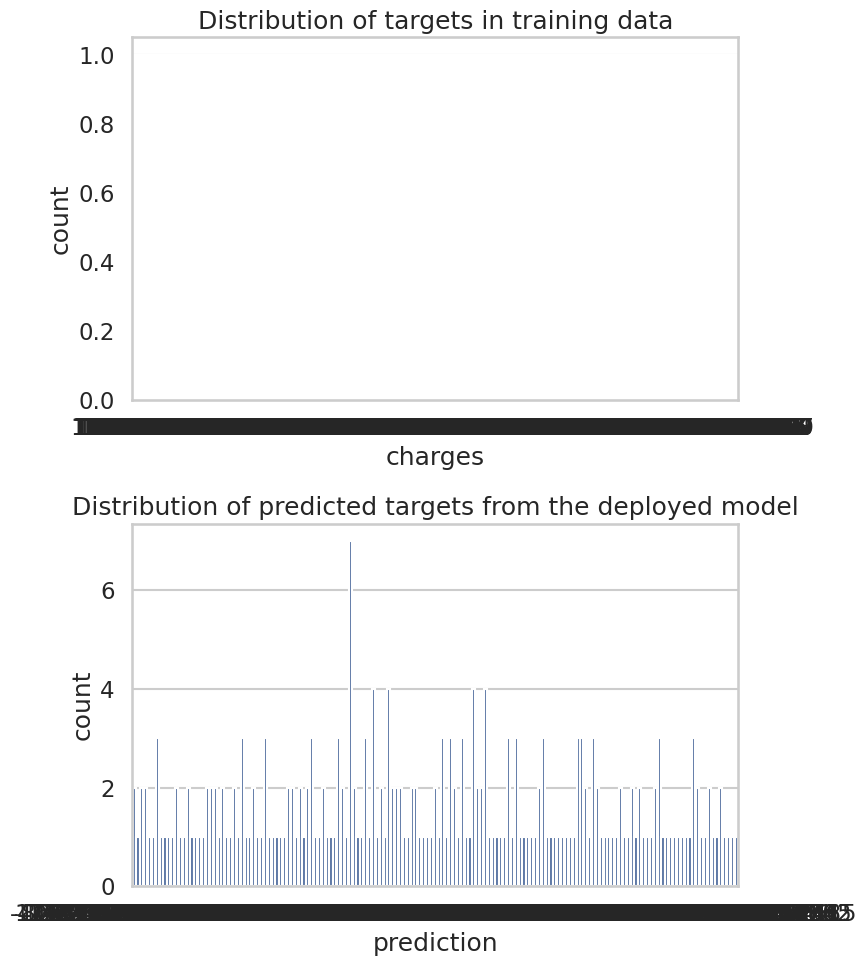

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and subplots
plt.figure(figsize=(9, 10))  # Adjusted the figure size for better spacing

# Plot the distribution of targets in training data
plt.subplot(211)
sns.countplot(x=ytrain)
plt.title("Distribution of targets in training data")

# Plot the distribution of predicted targets from the deployed model
plt.subplot(212)
sns.countplot(x=prediction_logs_sample_df.prediction)
plt.title("Distribution of predicted targets from the deployed model")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [88]:
# Calculate mean of actual values in training data (sum(target y) / len(target y))
target_mean = sum(ytrain) / len(ytrain)

In [89]:
import numpy as np

In [90]:
# Calculate mean of predicted values in sample logs (sum(logs.prediction) / len(logs.prediction))

# Calculate the sum of the 'prediction' column
sum_prediction = prediction_logs_sample_df['prediction'].sum()

# Calculate the length of the 'prediction' column
len_prediction = len(prediction_logs_sample_df['prediction'])

# Calculate the mean of the 'prediction' column
mean_prediction = sum_prediction / len_prediction

# Print the results
print(f"The sum of the predictions is: {sum_prediction}")
print(f"The number of predictions is: {len_prediction}")
print(f"The mean of the predictions is: {mean_prediction}")

The sum of the predictions is: 3357687.704052684
The number of predictions is: 247
The mean of the predictions is: 13593.877344342849


In [91]:
# Calculate variance of actual values in training data
variance = sum((y - target_mean)**2 for y in ytrain) / len(ytrain)

In [92]:
variance

144333621.93314752

In [95]:
diff = abs(target_mean - mean_prediction)

In [96]:
# Check for model drift
if diff > 2 * math.sqrt(variance):
    print("Model Drift Detected!")
else:
    print("No Model Drift!")

No Model Drift!


## Data Drift Checks

### Live Features vs Training Features

In [100]:
print("Columns in Xtrain:", Xtrain.columns)
print("Columns in prediction_logs_sample_df:", prediction_logs_sample_df.columns)

# Calculate mean and standard deviation of 'Children' in Xtrain
mean_children_training_data = Xtrain['children'].mean()
std_children_training_data = Xtrain['children'].std()

# Calculate mean of 'Children' in prediction_logs_sample_df
mean_children_sample_logs = prediction_logs_sample_df['Children'].mean()

# Print the results
print(f"Mean number of children in training data: {mean_children_training_data}")
print(f"Standard deviation of number of children in training data: {std_children_training_data}")
print(f"Mean number of children in sample logs: {mean_children_sample_logs}")

Columns in Xtrain: Index(['age', 'bmi', 'children', 'sex', 'smoker', 'region'], dtype='object')
Columns in prediction_logs_sample_df: Index(['Age', 'BMI', 'Children', 'Sex', 'Smoker', 'Region', 'prediction'], dtype='object')
Mean number of children in training data: 1.1074766355140186
Standard deviation of number of children in training data: 1.2159834305542554
Mean number of children in sample logs: 1.2619433198380567


In [102]:
(mean_children_training_data, mean_children_sample_logs)

(1.1074766355140186, 1.2619433198380567)

In [104]:
mean_feature_training_data = 39.35
mean_feature_sample_logs = 37.04
std_feature_training_data = 14.07

mean_diff = abs(mean_feature_training_data - mean_feature_sample_logs)

if mean_diff > 2 * std_feature_training_data:
    print("Data Drift Detected!")
else:
    print("No Data Drift!")

No Data Drift!


The current model stays in production unless we detect model drift or data drift.

# Convert ipynb to HTML

Instructions:
1. Go to File
2. Download these current working Notebook in to ipynb format
3. Now, run the below code, select the notebook from local where you downloaded the file
4. Wait for few sec, your notebook will automatically converted in to html format and save in your local pc


In [1]:
import os
os.system('jupyter nbconvert --to html Dr_Amobi_learner_insurance_charge_prediction.7.25.24.ipynb')

1

## Power Ahead!